In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from pydmd import DMDc
from pydmd.plotter import plot_eigs
import os
import re
from flowtorch.data import FOAMDataloader, mask_box
import torch as pt

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [117]:
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.0"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)
u_inlet = 1.0
p = np.array(loader.load_snapshot("p", times[1:]))
#normaling p
p = p[:, 399:]/u_inlet**2

u_x = np.array(loader.load_snapshot("U", times[1:]))[:,0,:]

#normalizing u_x
u_x = u_x[:, 399:]/u_inlet

u_y = np.array(loader.load_snapshot("U", times[1:]))[:,1,:]
#normalizing u_x
u_y = u_y[:, 399:]/u_inlet

print(p.shape, u_x.shape, u_y.shape)

state_matrix = np.vstack((p, u_x, u_y))

times_num = np.array(list(map(float, times)))
times_num = times_num[400:]
#p = p[:, 399:]
A, f = 0.5, 3.0
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))


(21250,) (21250,)
(21250, 401) (21250, 401) (21250, 401)


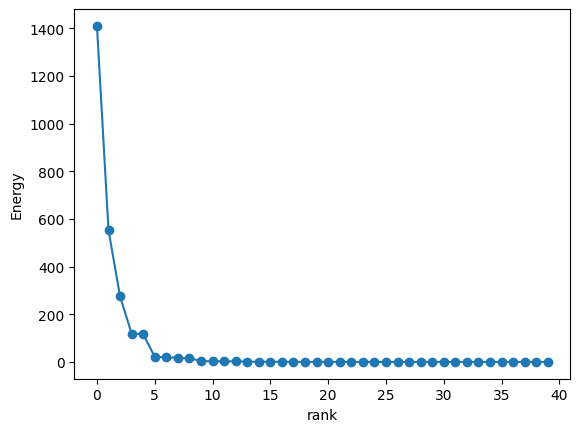

In [118]:
#Check for rank for reduced order modelling
U, S, Vh = pt.svd(pt.tensor(p))
plt.xlabel("rank")
plt.ylabel("Energy")
plt.plot(S[:40], marker = 'o')

In [119]:
#Splitting training and test data
train_test_ratio = 0.75
data = p
index = round(train_test_ratio*data.shape[1])
train_data = data[:,:index]
test_data = data[:,index:]
train_u = u[:,:index-1]
test_u = u[:,index-1:]
s = {"snapshots": train_data, "u": train_u, "test_snapshot": test_data, "test_u": test_u }
print(s["snapshots"].shape)
print(s["u"].shape)
print(s["test_snapshot"].shape)
print(s["test_u"].shape)


(21250, 301)
(1, 300)
(21250, 100)
(1, 100)


In [120]:
dmdc = DMDc(svd_rank= 20)
dmdc.fit(s["snapshots"], s["u"])

/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 858215744.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [121]:
#reconstructing the data
reconstructed_data = dmdc.reconstructed_data()
reconstructed_data.shape

(21250, 301)

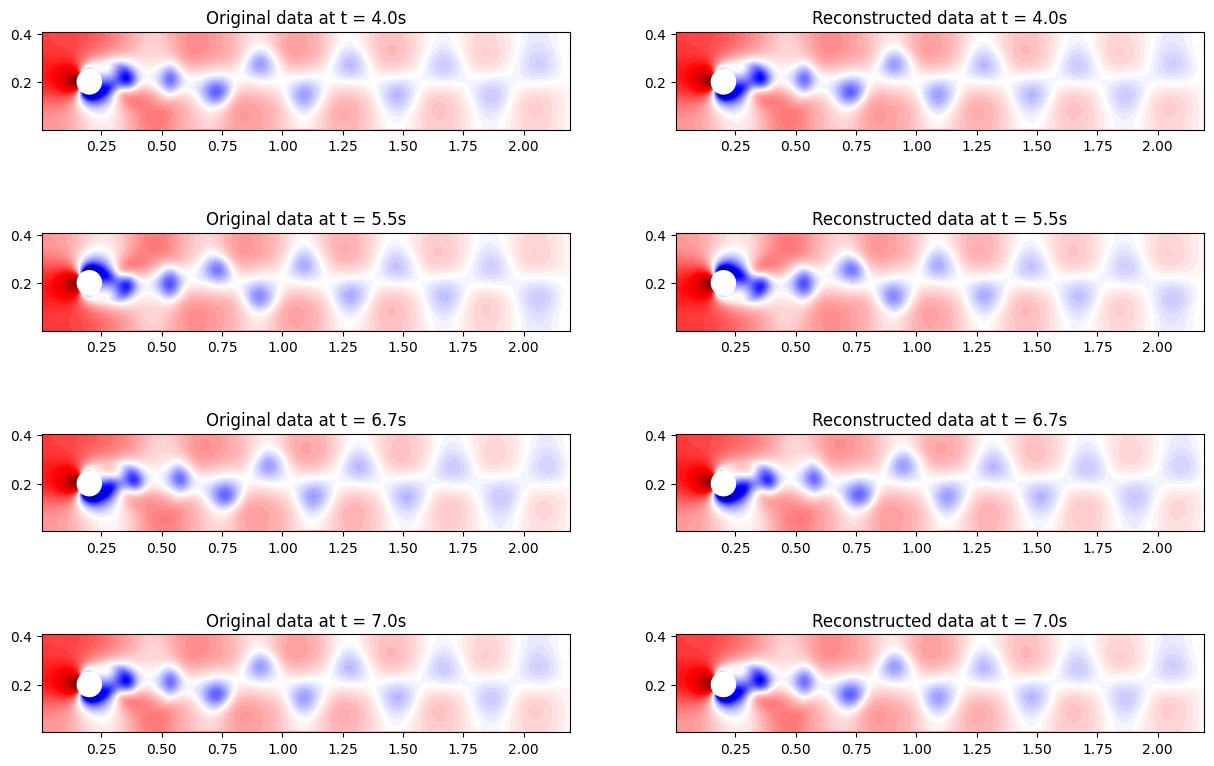

In [122]:
# Visualizing reconstructed data
vmin, vmax = s["snapshots"].min(), s["snapshots"].max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 150, 270, 300]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, s["snapshots"][:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original data at t = {}s".format(time*0.01+4))

    ax[i,1].tricontourf(x, y, reconstructed_data[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Reconstructed data at t = {}s".format(time*0.01+4))


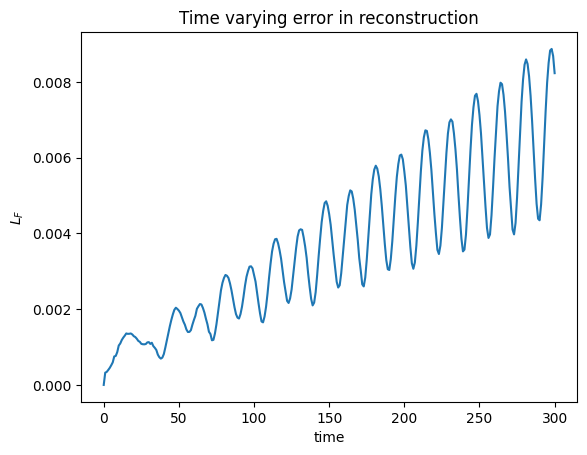

In [123]:
# Evaluating error in reconstruction
error = np.linalg.norm(s["snapshots"]-reconstructed_data, axis = 0)/np.linalg.norm(s["snapshots"], axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{F}$")
plt.title("Time varying error in reconstruction")
plt.plot(error)
plt.show()

In [124]:
# Predicting future flow evolution

A_tilde = dmdc._Atilde._Atilde
print(A_tilde.shape)
B_tilde = dmdc.basis.T.dot(dmdc.B)
print(B_tilde.shape)



(20, 20)
(20, 1)


In [126]:
x_curr = dmdc.basis.T.dot(s["snapshots"][:,-1]) #need to use original or recontructed data to initialize?
x_curr = x_curr.reshape(len(x_curr),1)
print(x_curr.shape)
predicted_flow_tilde = np.empty((len(x_curr), 0))
for i in range(s["test_snapshot"].shape[1]):
    x_curr = A_tilde.dot(x_curr) + B_tilde.dot(s["test_u"][0,i])
    predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))
print(predicted_flow_tilde.shape)

(20, 1)
(20, 100)


In [127]:
# Projecting predicted flow to full rank
predicted_flow = dmdc.basis.dot(predicted_flow_tilde)
print(predicted_flow.shape)

(21250, 100)


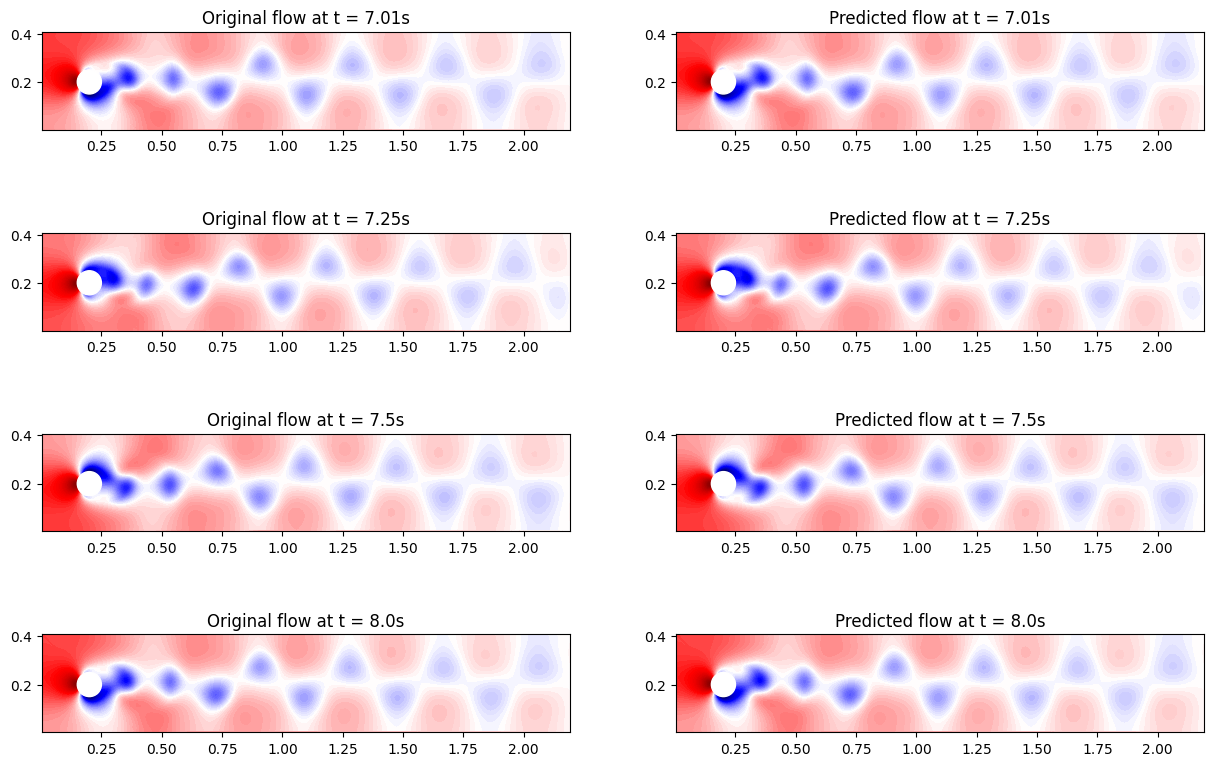

In [128]:
# Visualizing predicted flow to original flow
vmin, vmax = s["test_snapshot"].min(), s["test_snapshot"].max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 24, 49, 99]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, s["test_snapshot"][:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original flow at t = {}s".format(time*0.01+7.01))

    ax[i,1].tricontourf(x, y, predicted_flow[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Predicted flow at t = {}s".format(time*0.01+7.01))

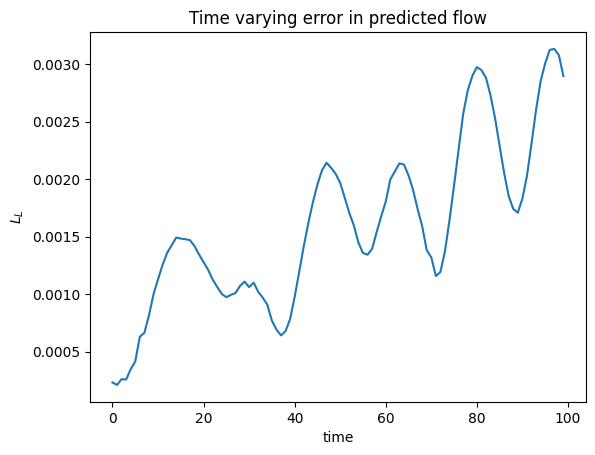

In [129]:
# Evaluating error in predicted flow
error_predicted = np.linalg.norm(s["test_snapshot"]-predicted_flow, axis = 0)/np.linalg.norm(s["test_snapshot"], axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{L}$")
plt.title("Time varying error in predicted flow")
plt.plot(error_predicted)
plt.show()

In [130]:
# Computing solution for unforced case
new_u = np.zeros(s["u"].shape)
#new_u = np.zeros(400)
predicted_unforced_flow = dmdc.reconstructed_data(new_u).real


In [131]:
#error in unforced case

folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/temp/unforced_case/simulation"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times

p_unforced = np.array(loader.load_snapshot("p", times[1:]))[:,399:700]
print(p_unforced.shape)

(21250, 301)


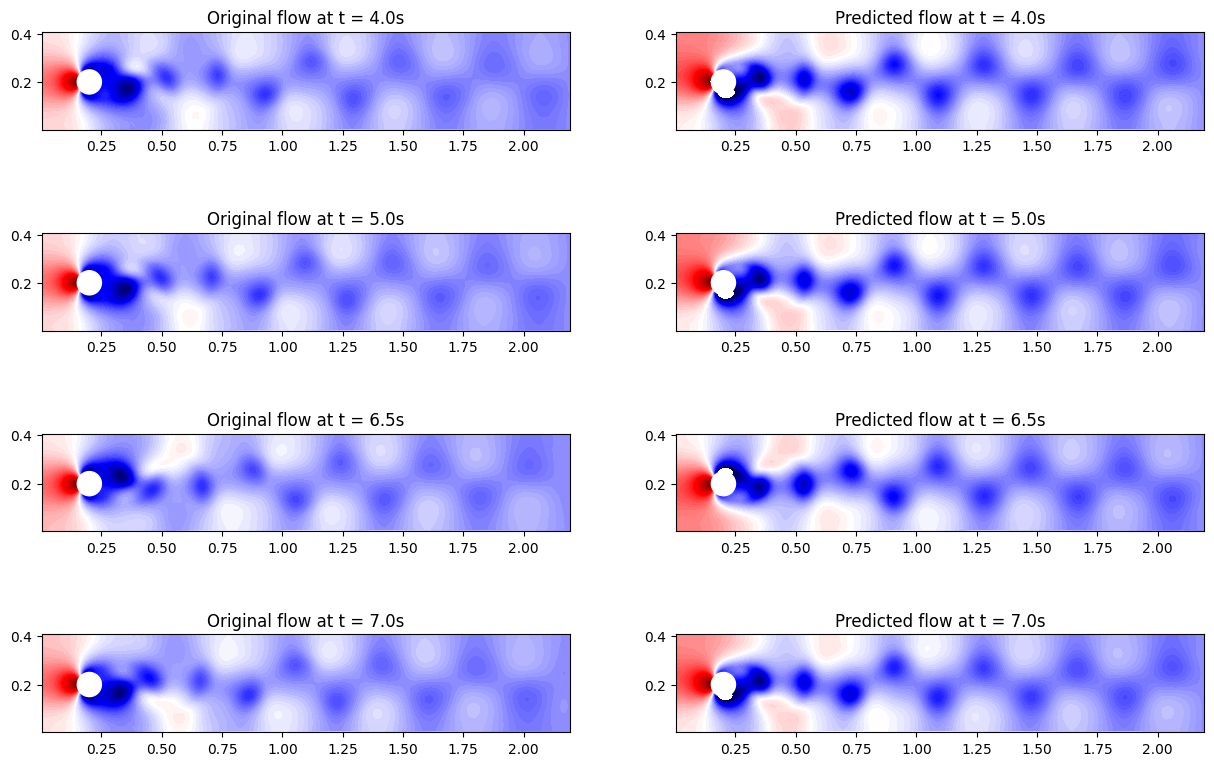

In [132]:
# Visualizing predicted flow for unforced case to original flow
vmin, vmax = p_unforced.min(), p_unforced.max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 100, 250, 300]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, p_unforced[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original flow at t = {}s".format(time*0.01+4))

    ax[i,1].tricontourf(x, y, predicted_unforced_flow[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Predicted flow at t = {}s".format(time*0.01+4))

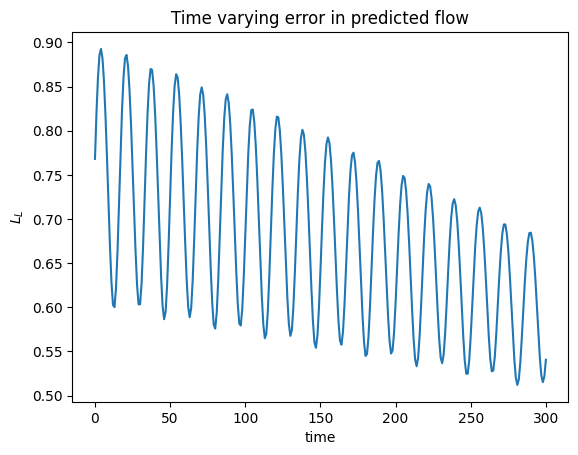

In [133]:
# Evaluating error in predicted flow
error_predicted = np.linalg.norm(p_unforced-predicted_unforced_flow, axis = 0)/np.linalg.norm(p_unforced, axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{L}$")
plt.title("Time varying error in predicted flow")
plt.plot(error_predicted)
plt.show()

In [134]:
# Predicting the flow for unforced case using initial value from unforced case using reduced order matrices
# The initial state for forced and unforced case will be different at t = 4s
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/temp/unforced_case/simulation"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times

p_unforced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_unforced.shape)

x_curr = np.array(loader.load_snapshot("p", times[1:]))[:,398]
x_curr = dmdc.basis.T.dot(x_curr)
x_curr = x_curr.reshape(len(x_curr), 1)
time_unforced = np.array(range(399, 800))/100
#print("time", time_unforced.shape)
                         
u_unforced = np.atleast_2d(A*np.sin(2*np.pi*f*time_unforced))
print(u_unforced.shape)
predicted_flow_unforced_tilde = np.empty((len(x_curr), 0))
for i in range(p_unforced.shape[1]):
    x_curr = A_tilde.dot(x_curr) + B_tilde.dot(u_unforced[0,i])
    predicted_flow_unforced_tilde = np.hstack((predicted_flow_unforced_tilde,x_curr))
print(predicted_flow_unforced_tilde.shape)

(21250, 401)
(1, 401)
(20, 401)


In [135]:
# Projecting predicted flow to full rank
predicted_flow_unforced = dmdc.basis.dot(predicted_flow_unforced_tilde)
print(predicted_flow_unforced.shape)

(21250, 401)


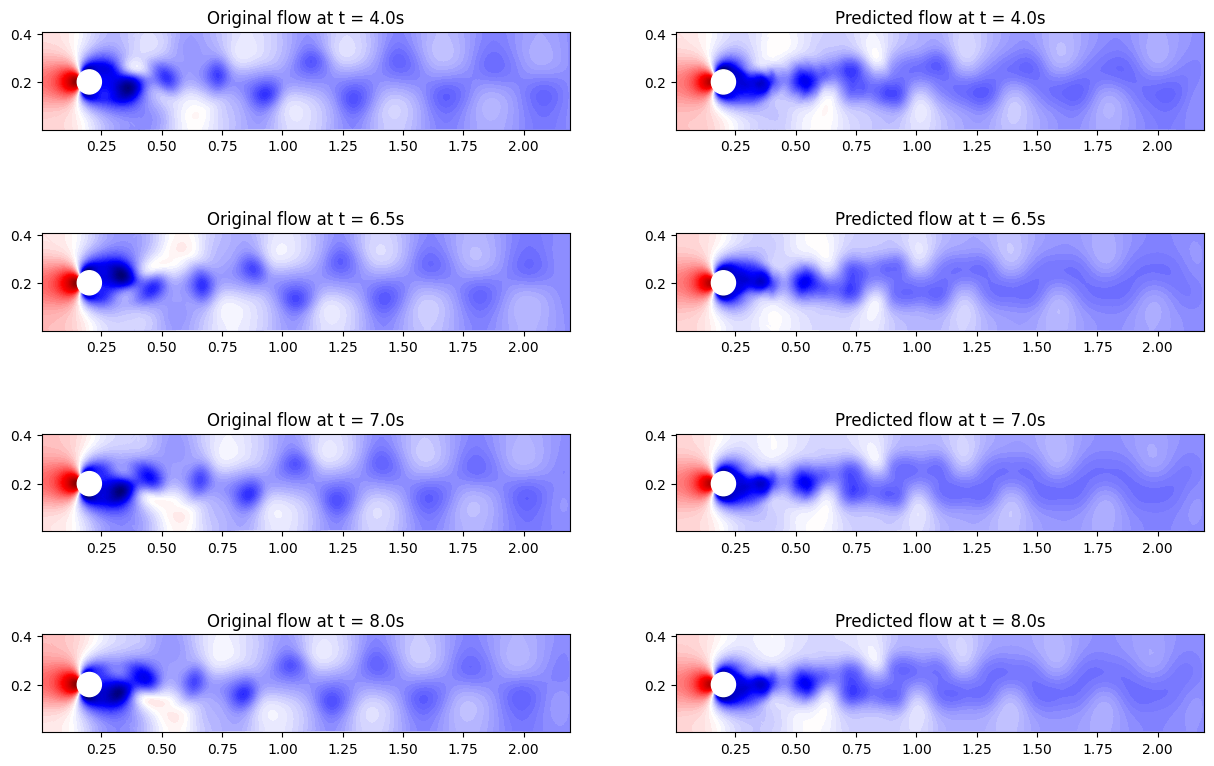

In [136]:
# Visualizing predicted flow for unforced case to original flow
vmin, vmax = p_unforced.min(), p_unforced.max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 250, 300, 400]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, p_unforced[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original flow at t = {}s".format(time*0.01+4))

    ax[i,1].tricontourf(x, y, predicted_flow_unforced[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Predicted flow at t = {}s".format(time*0.01+4))

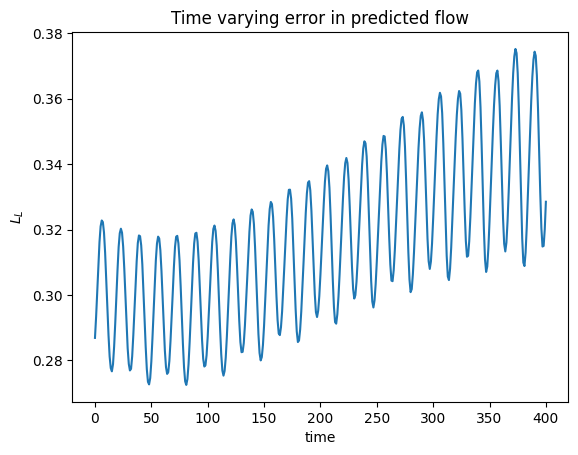

In [137]:
# Evaluating error in predicted flow
error_predicted = np.linalg.norm(p_unforced-predicted_flow_unforced, axis = 0)/np.linalg.norm(p_unforced, axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{L}$")
plt.title("Time varying error in predicted flow")
plt.plot(error_predicted)
plt.show()

In [116]:
"""
# Computing solution for forced case A = 0.5 f = 1.5
A, f = 0.5, 1.5
u_freq_1pt5 = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
sol_freq_1pt5 = dmdc.reconstructed_data(u_freq_1pt5).real

#error in forced case
p_dmdc_freq_1pt5 = sol_freq_1pt5*(p_max-p_min)+p_min

folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f1.5"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times

p_freq_1pt5 = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_freq_1pt5.shape)
rel_err = np.linalg.norm((p_freq_1pt5-p_dmdc_freq_1pt5))/np.linalg.norm(p_freq_1pt5)
print("Relative error between the pressure fields for frequnecy ratio 0.5 and amplitude 0.5 case is = ",rel_err)
abs_err = np.linalg.norm((p_freq_1pt5-p_dmdc_freq_1pt5))
print("Absolute error between the pressure fields for frequnecy ratio 0.5 and amplitude 0.5 case is = ",abs_err)
"""

'\n# Computing solution for forced case A = 0.5 f = 1.5\nA, f = 0.5, 1.5\nu_freq_1pt5 = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))\nsol_freq_1pt5 = dmdc.reconstructed_data(u_freq_1pt5).real\n\n#error in forced case\np_dmdc_freq_1pt5 = sol_freq_1pt5*(p_max-p_min)+p_min\n\nfolder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f1.5"\nloader = FOAMDataloader(folder_path, distributed=True)\ntimes = loader.write_times\n\np_freq_1pt5 = np.array(loader.load_snapshot("p", times[1:]))[:,399:]\nprint(p_freq_1pt5.shape)\nrel_err = np.linalg.norm((p_freq_1pt5-p_dmdc_freq_1pt5))/np.linalg.norm(p_freq_1pt5)\nprint("Relative error between the pressure fields for frequnecy ratio 0.5 and amplitude 0.5 case is = ",rel_err)\nabs_err = np.linalg.norm((p_freq_1pt5-p_dmdc_freq_1pt5))\nprint("Absolute error between the pressure fields for frequnecy ratio 0.5 and amplitude 0.5 case is = ",abs_err)\n'